# Import Packages and Reading of Data

In [1]:
import time
import warnings
import pickle

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from bayes_opt import BayesianOptimization
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, classification_report

import xgboost as xgb # recommended version: 1.5.0
from xgboost import plot_importance

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
# Reading of Excel
dataset = pd.read_csv('cleaned_others_dataset.csv')
dataset

,verified,location,followers_count,following_count,tweet_count,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,0,1997,5,17090,1,15,1,0,19,0,1,2,0,0,1,2016,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,0,1,785,829,251,0,12,0,1,8,0,1,0,0,0,1,2016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,243,1232,1469,0,8,0,1,11,0,0,0,0,0,1,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,737048,128,4739,0,13,0,1,14,0,1,1,0,0,1,2012,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1,281703,1599,14785,0,14,0,0,16,0,1,1,0,1,1,2009,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24549,1,0,2025977,947,194749,0,11,1,0,13,0,1,1,0,0,1,2009,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
24550,1,1,367523,17291,24084,0,14,0,1,10,0,1,2,0,0,1,2009,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
24551,0,0,395,492,21437,1,14,0,1,16,0,1,0,0,0,1,2012,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
24552,0,0,159,618,3021,0,8,0,1,14,0,1,0,0,0,0,2015,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


# Feature Engineering

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=["isFraud"]), dataset["isFraud"], test_size = 0.2, random_state=101)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (19643, 35) (19643,)
Test set: (4911, 35) (4911,)


In [4]:
scaler = StandardScaler()
fitted = scaler.fit(X_train)
X_train_fitted = fitted.transform(X_train)
X_test_fitted = fitted.transform(X_test)

In [5]:
x_train = pd.DataFrame(X_train_fitted, columns = X_train.columns)
x_test = pd.DataFrame(X_test_fitted, columns = X_test.columns)
y_train = pd.DataFrame(y_train, columns = ["isFraud"])
y_test = pd.DataFrame(y_test, columns = ["isFraud"])
print(x_train.shape,
      y_train.shape,
      x_test.shape,
      y_test.shape
      )

(19643, 35) (19643, 1) (4911, 35) (4911, 1)


# XGBoost
* Model (Grid Search + Randomized Search + Bayesian Optimisation)
* Error Metrics
* Plot for Feature Importance

### Grid Search

In [39]:
estimators = xgb.XGBClassifier(
                       gamma = 0.1,
                       alpha = 0.5,
                       objective = "binary:logistic",
                       eval_metric = "logloss")

parameters = {
    'max_depth': [6, 10, 15, 20, 25],
    'subsample': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2], 
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],  
}
    
grid_search = GridSearchCV(
    estimator=estimators,
    scoring = 'f1',
    param_grid=parameters,
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [40]:
%%time

grid_search.fit(x_train, y_train)
# Fitting 5 folds for each of 225 candidates, totalling 1125 fits
# CPU times: user 9.5 s, sys: 649 ms, total: 10.2 s
# Wall time: 2h 36min 53s

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
CPU times: user 9.5 s, sys: 649 ms, total: 10.2 s
Wall time: 2h 36min 53s


GridSearchCV(cv=5,
             estimator=XGBClassifier(alpha=0.5, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0.1,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'eta': [0.01, 0.1, 0.2],
                         'max_depth': [6, 10, 15, 20, 25],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='f1', verbose=True)

In [41]:
#filename = 'grid_all.sav'
#pickle.dump(grid_search, open(filename, 'wb'))
print(random_search.best_params_)
print("Grid Search:", grid_search.best_score_)

{'subsample': 1.0, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.8}
Grid Search: 0.6465504842515439


### Randomized Search

In [28]:
estimators = xgb.XGBClassifier(
                       gamma = 0.1,
                       alpha = 0.5,
                       objective = "binary:logistic",
                       eval_metric = "logloss")


parameters = {
    'max_depth': [6, 10, 15, 20, 25],
    'subsample': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2], 
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],  
}
    
random_search = RandomizedSearchCV(
    estimator=estimators,
    param_distributions=parameters,
    scoring = 'f1',
    n_jobs = -1,
    cv = 5,
    verbose=10,
    n_iter=50,
    random_state=123
)

In [29]:
%%time

random_search.fit(x_train, y_train)
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# CPU times: user 7.27 s, sys: 118 ms, total: 7.39 s
# Wall time: 16min 17s

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5; 1/50] START colsample_bytree=0.8, eta=0.2, max_depth=25, subsample=0.6.
[CV 2/5; 1/50] END colsample_bytree=0.8, eta=0.2, max_depth=25, subsample=0.6;, score=0.860 total time=  14.0s
[CV 3/5; 2/50] START colsample_bytree=0.9, eta=0.2, max_depth=10, subsample=1.0.
[CV 3/5; 2/50] END colsample_bytree=0.9, eta=0.2, max_depth=10, subsample=1.0;, score=0.859 total time=   9.9s
[CV 5/5; 2/50] START colsample_bytree=0.9, eta=0.2, max_depth=10, subsample=1.0.
[CV 5/5; 2/50] END colsample_bytree=0.9, eta=0.2, max_depth=10, subsample=1.0;, score=0.860 total time=  10.0s
[CV 3/5; 3/50] START colsample_bytree=0.6, eta=0.1, max_depth=20, subsample=1.0.
[CV 3/5; 3/50] END colsample_bytree=0.6, eta=0.1, max_depth=20, subsample=1.0;, score=0.860 total time=  12.1s
[CV 2/5; 4/50] START colsample_bytree=0.5, eta=0.1, max_depth=10, subsample=1.0.
[CV 2/5; 4/50] END colsample_bytree=0.5, eta=0.1, max_depth=10, subsample=1.0;, score=0.8

CPU times: user 7.27 s, sys: 118 ms, total: 7.39 s
Wall time: 16min 17s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(alpha=0.5, base_score=None,
                                           booster=None, callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=0.1,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'eta': [0.01, 0.1, 0.2],
                                        'max_depth': [6, 10, 15, 20, 25],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=123, scoring='f1', verbose=10)

In [30]:
#filename = 'random_all.sav'
#pickle.dump(random_search, open(filename, 'wb'))

print(random_search.best_params_)
print("Randomised Search:", random_search.best_score_)

{'subsample': 1.0, 'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.8}
Randomised Search: 0.6465504842515439


### Bayesian Optimisation

In [8]:
def xgboost_hyper_pram(eta, max_depth, subsample, gamma, colsample_bytree, alpha):
    max_depth = int(max_depth)
    clf = xgb.XGBClassifier(max_depth = max_depth, 
                           eta = eta, 
                           gamma = gamma,
                           subsample = subsample,
                           colsample_bytree = colsample_bytree,
                           alpha = alpha,
                           objective = "binary:logistic",
                           eval_metric = "logloss")
    
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    return (metrics.f1_score(y_test, y_pred))

In [9]:
optim_model = BayesianOptimization(xgboost_hyper_pram, 
                                   {'max_depth' : (1, 30), 
                                   'eta' : (0, 0.5), 
                                   'gamma' : (0, 1),
                                   'subsample' : (0, 1),
                                   'colsample_bytree' : (0, 1),
                                   'alpha' : (0, 1)},
                                   random_state=123
                                  )

In [10]:
%%time 

optim_model.maximize(n_iter=15, init_points=25, acq='ei')

# CPU times: user 6min 26s, sys: 3.84 s, total: 6min 29s
# Wall time: 2min 19s

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.6265    | 0.6965    | 0.2861    | 0.1134    | 0.5513    | 21.86     | 0.4231    |
| 2         | 0.6457    | 0.9808    | 0.6848    | 0.2405    | 0.3921    | 10.95     | 0.729     |
| 3         | 0.5614    | 0.4386    | 0.05968   | 0.199     | 0.738     | 6.292     | 0.1755    |
| 4         | 0.635     | 0.5316    | 0.5318    | 0.3172    | 0.8494    | 22.01     | 0.611     |
| 5         | 0.6357    | 0.7224    | 0.323     | 0.1809    | 0.2283    | 9.518     | 0.631     |
| 6         | 0.6287    | 0.0921    | 0.4337    | 0.2154    | 0.4937    | 13.35     | 0.3123    |
| 7         | 0.5482    | 0.4264    | 0.8934    | 0.4721    | 0.5018    | 19.09     | 0.1156    |
| 8         | 0.6476    | 0.3173    | 0.4148    | 0.4332    | 0.2505    | 15.01     | 0.9856    |
| 9         | 0.6514

In [15]:
#filename = 'bayesian_all.sav'
#pickle.dump(optim_model, open(filename, 'wb'))

In [11]:
optim_model.max["params"]

{'alpha': 0.11924672227220723,
 'colsample_bytree': 0.6608263529085655,
 'eta': 0.09712654192063125,
 'gamma': 0.4695907765132531,
 'max_depth': 16.627038916243013,
 'subsample': 0.8061674803632113}

In [23]:
params = optim_model.max['params']
print("Best score:", optim_model.max["target"])

Best score: 0.656571119524067


### Comparing Model Scores

In [42]:
print("Grid Search:", grid_search.best_score_) 
print("Randomised Search:", random_search.best_score_) 
print("Bayesian Optimisation:", optim_model.max["target"]) 

Grid Search: 0.6465504842515439
Randomised Search: 0.6465504842515439
Bayesian Optimisation: 0.656571119524067


In [43]:
# Tuned hyperparameters using 
final_model_all = xgb.XGBClassifier(max_depth = int(params['max_depth']), 
                           eta = params['eta'], 
                           gamma = params['gamma'],
                           subsample = params['subsample'],
                           colsample_bytree = params['colsample_bytree'],
                           alpha = params['alpha'],
                           objective = "binary:logistic",
                           eval_metric = "logloss")

xgbmodel_all_tuned = final_model_all.fit(x_train, y_train)

In [22]:
#filename = 'final_all.sav'
#pickle.dump(xgbmodel_all_tuned, open(filename, 'wb'))

In [44]:
y_pred_all = xgbmodel_all_tuned.predict(x_test)

In [45]:
lg_loss = metrics.log_loss(y_test, y_pred_all)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_all)
print(f'ROC AUC: {roc_auc}')
precision = metrics.precision_score(y_test, y_pred_all)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_all)
print(f'Recall: {recall}')
f1_score = metrics.f1_score(y_test, y_pred_all)
print(f'F1-score: {f1_score}')
# 0.9801546391752578 gs
# 0.6515151515151515 rs
# 0.656571119524067 bo

Log Loss: 4.465941712888026
ROC AUC: 0.7577810649472405
Precision: 0.8061088977423638
Recall: 0.5538321167883211
F1-score: 0.656571119524067


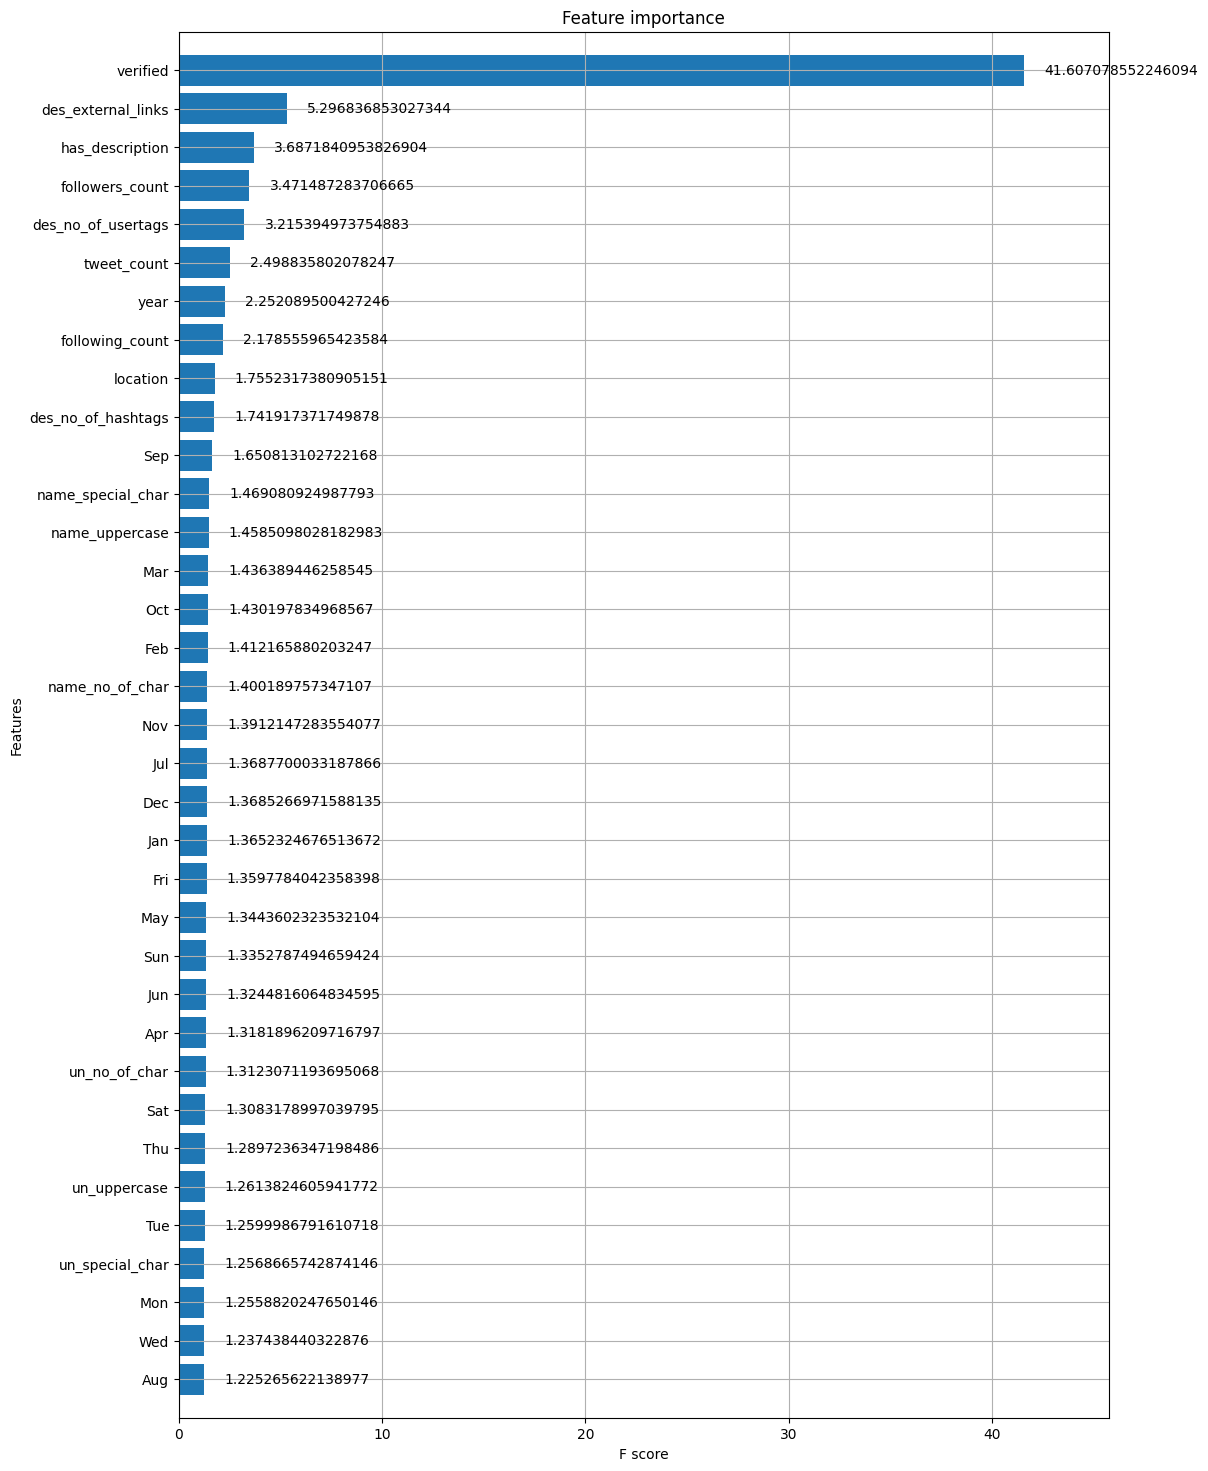

In [46]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgbmodel_all_tuned, importance_type = 'gain', height=0.8, ax=ax)
plt.show()